<h1 style="text-align: center;">Final Project </h1>

$\bullet$ __ We first download load the data __

In [50]:
import pandas as pd
import os

df_reviews = pd.DataFrame()
file_list = os.listdir("../yelp_dataset/reviews_filter.json")

for file in file_list:
    # loading the reviews into a dataframe
    df = pd.read_json("../yelp_dataset/reviews_filter.json/" + file, lines=True) #specify that json has multiple lines
    df_reviews = pd.concat([df_reviews, df])

# removing rows containing NaN value and reaffecting index to the df
df_reviews = df_reviews.dropna() 
df_reviews = df_reviews.reset_index(drop=True)

print(len(df_reviews))

474432


In [86]:
# loading the business into a dataframe
df_business = pd.DataFrame()
file_list = os.listdir("../yelp_dataset/open_business.json")
    
for file in file_list:
    # loading business into a dataframe
    df = pd.read_json("../yelp_dataset/open_business.json/" + file, lines=True) #specify that json has multiple lines
    df_business = pd.concat([df_business, df])

# removing rows containing NaN value and reaffecting index to the df
df_business = df_business.dropna() 
df_business = df_business.reset_index(drop=True)

print(len(df_business))

123374


In [3]:
print("Reviews keys : ", list(df_reviews.keys()))
print("Business keys : ", list(df_business.keys()))

Reviews keys :  ['business_id', 'date', 'review_id', 'stars', 'text', 'user_id']
Business keys :  ['address', 'business_id', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'review_count', 'stars', 'state']


<hr>

$\bullet$ __ The idea is now to filter the business dataframe in order to select only the business that have reviews__

In [87]:
list_business = list(df_reviews.business_id.unique())
print(len(list_business))

# selecting only the wanted business
df_business = df_business[df_business['business_id'].isin(list_business) == True]
df_business = df_business.reset_index(drop=True)
print(len(df_business.business_id.unique()))

# strange thing : the two following lists do not have the same length
# print(len(list_business) - len(df_business))
# print(list(set(list_business) - set(list(df_business.business_id.values))))

8191
7927


<hr>

# Analyze comment 

In [5]:
import nltk
from nltk import word_tokenize
labMT = pd.read_csv('data/s001.txt', sep="\t")

In [6]:
# function computing the sentimental value of a text
def computeSentiment(text):
    happiness_average, text = 0, word_tokenize(text)
    words = {word: text.count(word) for word in set(text)}
    
    for word in words:
        val_happiness = labMT[labMT["word"] == word].happiness_average.values
        # checking if the word is in labMT or not
        if len(val_happiness)>0:
            happiness_average += float(val_happiness[0]) * words[word] # taking into account the nb of occurences of the word
            
    return happiness_average / len(text)   

$\bullet$ __Now creating a dictionnary where keys are business id and value a list of all the comments related to this business. In order to compute the rating of each business. And another one where keys are business id and values the sentiment value__

In [7]:
dic_reviews = {business: [] for business in list_business}

for i in range(len(df_reviews)):
    comment = df_reviews.loc[i].text
    business = df_reviews.loc[i].business_id
    
    dic_reviews[business].append(comment)

KeyboardInterrupt: 

$\bullet$ __ Use the first cell to create a json file containing as a key the business id and as value the rate of the busines. Use the second one to load the data from the file.__

In [ ]:
import json
from statistics import mean
dic_rate = {}

for elt in list(dic_reviews.keys()):
    dic_rate[elt] = mean([computeSentiment(text) for text in dic_reviews[elt]])

with open("dic_rate.json",'w') as file:
    json.dump(dic_rate, file, indent=4)

In [88]:
import json

with open("dic_rate.json",'r') as file:
    dic_rate = json.load(file)

$\bullet$ __Ploting the distribution of the business mark__

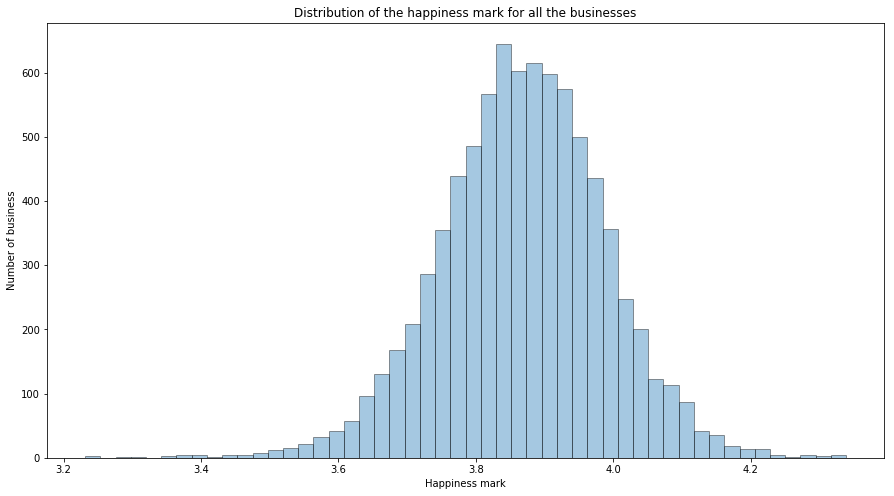

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'b'

df = pd.DataFrame.from_dict(dic_rate, orient='index')
sns.distplot(df, kde=False);
plt.title("Distribution of the happiness mark for all the businesses");
plt.xlabel("Happiness mark");
plt.ylabel("Number of business");
plt.savefig("Website/happiness_distribution.png")

<hr>

# Showing positions on a map

In [9]:
# filtering business in order to get business in a small area
df_business["latitude"] = pd.to_numeric(df_business["latitude"]) # changing type of the column to float
df_business["longitude"] = pd.to_numeric(df_business["longitude"])

# df_business = df_business[(df_business["longitude"] > -90) & (df_business['longitude'] < -85) &(df_business['latitude'] < 42)]
# df_business = df_business.reset_index(drop=True)
# print(len(df_business))

Use either one of the following locations :
<li> First one gets all business locations </li>
<li> Second one gets only the locations of the business which sentimental mark is computed</li>

In [10]:
# creating a list containing all localisations of business
locations = []
for i in range(len(df_business)):
    locations.append((df_business.loc[i].latitude, df_business.loc[i].longitude))

In [11]:
# creating a list containing the localisations of all the analyzed business
locations = {}
for business in list(dic_rate.keys()):
    try:
        locations[business] =((df_business[df_business['business_id'] == business].latitude.values[0], df_business[df_business['business_id'] == business].longitude.values[0]))
    except IndexError:
        pass

In [12]:
import statistics

# here we compute the color of each marker (business) regarding their final mark
max_rate = max(dic_rate.values())
med_rate = statistics.median(dic_rate.values())
min_rate = min(dic_rate.values())

def aggregateColors(rate):
    if rate <= med_rate:
        x = int(255*(rate - min_rate)/(med_rate - min_rate))
        return (255, x, 0, 0.8)
    else:
        x = int(255*(rate - med_rate)/(max_rate - med_rate))
        return (255 - x, 255, 0, 0.8)

colors = [aggregateColors(dic_rate[elt]) for elt in list(locations.keys())]
print(len(locations))
print(len(colors))

7927
7927


In [16]:
import gmaps
gmaps.configure(api_key='API_KEY')

place_focus = (33.448376, -112.074036) #focusing on phenix
fig = gmaps.figure(
        center = place_focus,
        zoom_level = 10)
symbols = gmaps.symbol_layer(
        list(locations.values()), 
        fill_color=colors, 
        stroke_color=colors)
fig.add_layer(symbols)

# hm = gmaps.heatmap_layer(locations, weights=rate, max_intensity=max(rate), point_radius=5.0)
# fig.add_layer(hm)

# fig

<hr>

# Trying to operate business categories

$\bullet$ __Changing the type of the column categories to a list__

In [89]:
df_business.categories = df_business.categories.astype(list)
df_business.categories = df_business['categories'].map(lambda a: a.split(",")) # spliting each element of row into a list

$\bullet$ __Finding which categories are the most used__

In [90]:
# function returning a dictionnary with key string and value the nb of occurence
def countingOccurencesListOfLists(list_of_lists):
    flattened = [val.lstrip() for sublist in list_of_lists for val in sublist] # flattening the list of lists
    dic = {key : 0 for key in flattened}
    for row in list_of_lists:
        for elt in row:
            dic[elt.lstrip()] += 1
            
    return dic

In [95]:
import operator

# sorting the tuples according to their nb of occurences
a = countingOccurencesListOfLists(list(df_business.categories.values))
a = sorted(a.items(), key=lambda item: (item[1], item[0]), reverse=True)
print(a[:10])

[('Restaurants', 5518), ('Food', 1724), ('Nightlife', 1486), ('Bars', 1399), ('American (Traditional)', 907), ('American (New)', 724), ('Breakfast & Brunch', 708), ('Sandwiches', 650), ('Pizza', 554), ('Italian', 536)]


$\bullet$ __Filter the business by a list of categories__

In [96]:
# filteringItems = [elt[0] for elt in a[133:143]]
# filteringItems=['Nightlife']

def filterDfByListElement(filteringList, df, column):
    indexToDrop = []
    for i in range(len(df)):
        categories = df.loc[i][column]
        if len(set(categories) & set(filteringList)) == 0:
            indexToDrop.append(i)
            
    df = df.drop(indexToDrop)
    df = df.reset_index(drop=True)
    return df

<hr>

# Trying to compare the rate distribution between to business categories

$\bullet$ __Get the sentiment analyzis for the filtered businesses__

In [190]:
import itertools as it
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

# filtering the businesses by two different categories
list_categories = ['Restaurants', 'Nightlife', "Bars", "Breakfast & Brunch", "Sandwiches", "Pizza", "Italian"]

categorie1, categorie2 = 'Restaurants', 'Nightlife'
    
df_filtered_business_1 = filterDfByListElement([categorie1], df_business, 'categories')
df_filtered_business_2 = filterDfByListElement([categorie2], df_business, 'categories')

# getting a list of business_id from both dataframes
list_filter_business_id_1 = list(df_filtered_business_1.business_id.values)
list_filter_business_id_2 = list(df_filtered_business_2.business_id.values)

In [191]:
dic_filtered_1 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_1}
dic_filtered_2 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_2}

$\bullet$ __Ploting the distribution of rates according to a specified category__

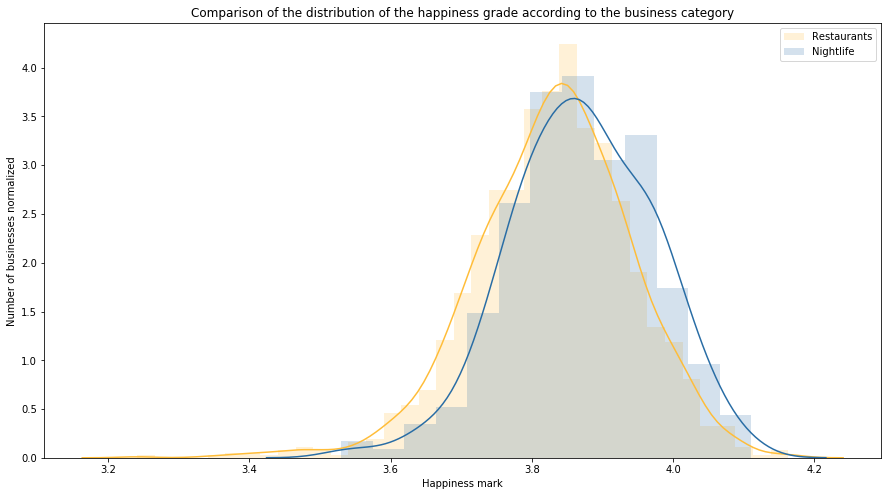

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

df1 = pd.DataFrame.from_dict(dic_filtered_1, orient='index')
df2 = pd.DataFrame.from_dict(dic_filtered_2, orient='index')

sns.distplot(df1, label=categorie1, hist_kws=dict(alpha=.2), color="#FFBD39");
sns.distplot(df2, label=categorie2, hist_kws=dict(alpha=.2), color="#296DA5");
plt.title("Comparison of the distribution of the happiness grade according to the business category");
plt.xlabel("Happiness mark");
plt.ylabel("Number of businesses normalized");
plt.legend();
# plt.savefig("Website/%s_%s.png" %(categorie1, categorie2))

$\bullet$ __Plotting the distribution of grades for the 7 main categories__

In [169]:
categorie1, categorie2, categorie3, categorie4, categorie5, categorie6, categorie7 = 'Restaurants', 'Nightlife', "Bars", "Breakfast & Brunch", "Sandwiches", "Pizza", "Italian"

df_filtered_business_1 = filterDfByListElement([categorie1], df_business, 'categories')
df_filtered_business_2 = filterDfByListElement([categorie2], df_business, 'categories')
df_filtered_business_3 = filterDfByListElement([categorie3], df_business, 'categories')
df_filtered_business_4 = filterDfByListElement([categorie4], df_business, 'categories')
df_filtered_business_5 = filterDfByListElement([categorie5], df_business, 'categories')
df_filtered_business_6 = filterDfByListElement([categorie6], df_business, 'categories')
df_filtered_business_7 = filterDfByListElement([categorie7], df_business, 'categories')

list_filter_business_id_1 = list(df_filtered_business_1.business_id.values)
list_filter_business_id_2 = list(df_filtered_business_2.business_id.values)
list_filter_business_id_3 = list(df_filtered_business_3.business_id.values)
list_filter_business_id_4 = list(df_filtered_business_4.business_id.values)
list_filter_business_id_5 = list(df_filtered_business_5.business_id.values)
list_filter_business_id_6 = list(df_filtered_business_6.business_id.values)
list_filter_business_id_7 = list(df_filtered_business_7.business_id.values)

dic_filtered_1 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_1}
dic_filtered_2 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_2}
dic_filtered_3 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_3}
dic_filtered_4 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_4}
dic_filtered_5 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_5}
dic_filtered_6 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_6}
dic_filtered_7 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_7}

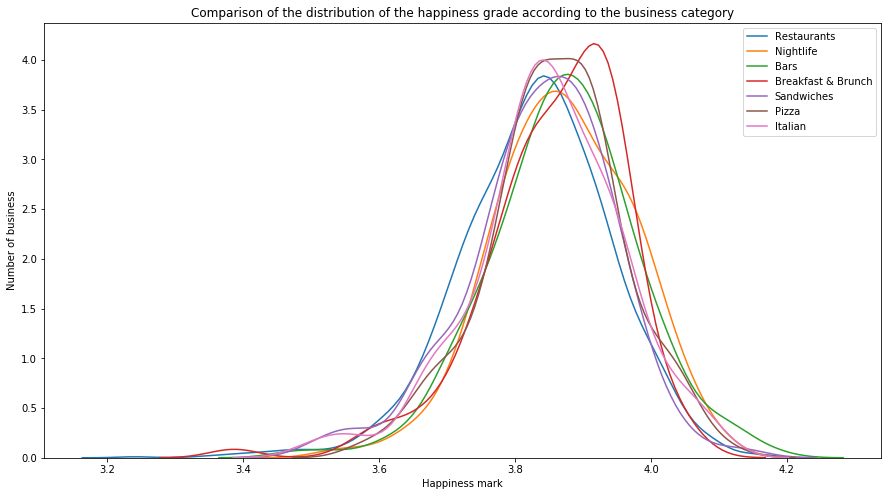

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

df1 = pd.DataFrame.from_dict(dic_filtered_1, orient='index')
df2 = pd.DataFrame.from_dict(dic_filtered_2, orient='index')
df3 = pd.DataFrame.from_dict(dic_filtered_3, orient='index')
df4 = pd.DataFrame.from_dict(dic_filtered_4, orient='index')
df5 = pd.DataFrame.from_dict(dic_filtered_5, orient='index')
df6 = pd.DataFrame.from_dict(dic_filtered_6, orient='index')
df7 = pd.DataFrame.from_dict(dic_filtered_7, orient='index')


# sns.distplot(df1, label=categorie1, hist_kws=dict(alpha=.2));
sns.distplot(df1, label=categorie1, hist=False);
sns.distplot(df2, label=categorie2, hist=False);
sns.distplot(df3, label=categorie3, hist=False);
sns.distplot(df4, label=categorie4, hist=False);
sns.distplot(df5, label=categorie5, hist=False);
sns.distplot(df6, label=categorie6, hist=False);
sns.distplot(df7, label=categorie7, hist=False);

plt.title("Comparison of the distribution of the happiness grade according to the business category");
plt.xlabel("Happiness mark");
plt.ylabel("Number of business");
plt.legend();
plt.savefig("Website/happiness_comparison_categories.png")

<hr>

# Network of elite users with friends

In [ ]:
import pandas as pd
import os

df_elite = pd.DataFrame()
file_list = os.listdir("../yelp_dataset/elite_users_with_friends.json")

for file in file_list:
    # loading the reviews into a dataframe
    df = pd.read_json("../yelp_dataset/elite_users_with_friends.json/" + file, lines=True) #specify that json has multiple lines
    df_elite = df_elite.append(df, ignore_index=True)
    
df_elite = df_elite.dropna() 
df_elite = df_elite.reset_index(drop=True)

$\bullet$ __Setting 'friend' and 'elite' columns as list__

In [ ]:
df_elite.elite = df_elite.elite.astype(list)
df_elite.elite = df_elite['elite'].map(lambda a: a.split(",")) # spliting each element of row into a list

In [ ]:
elite_2010 = filterDfByListElement(['2008'], df_elite, 'elite')

<hr>

# Network business

In [17]:
import os
import pandas as pd

df_users_business = pd.DataFrame()
# loading json file with key users and values business they have written a comment about
folder = os.listdir("../yelp_dataset/elite_and_business.json")

for file in folder:
    df = pd.read_json("../yelp_dataset/elite_and_business.json/" + file, lines=True)
    df_users_business = pd.concat([df_users_business, df])
    
print(len(df_users_business))

800951


In [18]:
# filtering the business that have less than 100 elite visitors
df_users_business = df_users_business.groupby("business_id").filter(lambda x: len(x) > 100)

In [19]:
# transform the group by into a dic where key is id and the value is a list of business_id
# in order to be able to draw edges between business linked by a common user
dic = df_users_business.groupby('user_id')['business_id'].apply(lambda x: x.tolist()).to_dict()

In [20]:
import networkx as nx
import itertools as it

G = nx.Graph()

for key in dic.keys():
    if len(dic[key]) > 1 and len(dic[key]) < 3:
        edges_to_draw = list(it.combinations(dic[key], 2)) #getting all 2-uples combination of the businesses
        G.add_edges_from(edges_to_draw)

In [21]:
import fa2
import matplotlib.pyplot as plt

forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G,
                                                    pos=None,
                                                    iterations=8000);

100%|██████████| 8000/8000 [00:48<00:00, 135.63it/s]

BarnesHut Approximation  took  15.88  seconds
Repulsion forces  took  29.43  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.32  seconds
AdjustSpeedAndApplyForces step  took  1.31  seconds


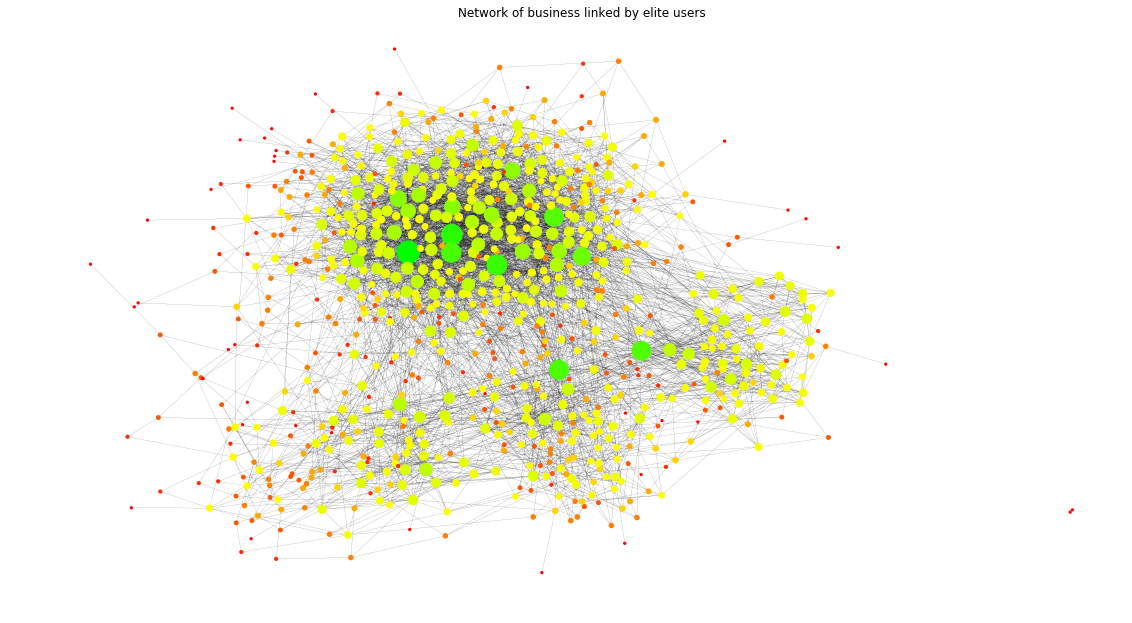

In [24]:
import statistics
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 8];

node_size = []
for elt in list(G.degree()):
    node_size.append(elt[1]*5)
    
# here we compute the color of each node regarding their degree
max_size = max(node_size)
med_size = statistics.median(node_size)
min_size = min(node_size)

def aggregateColors(size):
    if size <= med_size:
        x = int(255*(size - min_size)/(med_size - min_size))
        return (1,x/255,0)
    else:
        x = int(255*(size - med_size)/(max_size - med_size))
        return ((255 - x)/255,1,0)

colors = [aggregateColors(size) for size in node_size]

nx.draw(G, positions, node_size=node_size, node_color=colors, width=.1)
plt.title("Network of business linked by elite users")
plt.savefig("network_business.png")

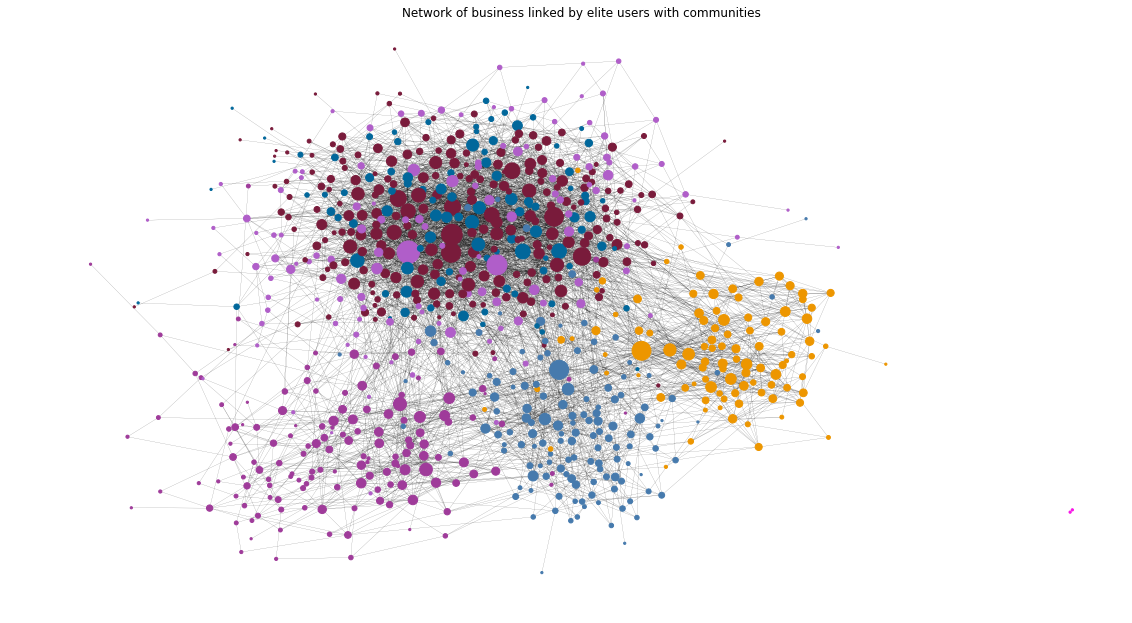

In [28]:
import community
import numpy as np

partition = community.best_partition(G)
node_color_indices = [node[1] for node in partition.items()]
partColors = {i: list(np.random.random(size=3)) for i in set(node_color_indices)}
node_colors = [partColors[index] for index in node_color_indices]

nx.draw(G, positions, node_color=node_colors, node_size=node_size, width=.1)
plt.title("Network of business linked by elite users with communities")
plt.savefig("network_business_communities.png")

In [195]:
a = [(1,0.343242), (4, 0.2342458), (2,.45345345), (6, .24234242)]
a[-1]

(6, 0.24234242)

[(1, 0.343242), (4, 0.2342458), (2, 0.45345345), (6, 0.24234242)]

## Getting Elite users with Elite friends

We have chosen the _relevant_ users, meaning by that those users that follow these requisites:
- they are categorised as _elite_ in the year 2017,
- have at least 10 followers,
- reviewed at least 50 businesses.

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import os
import json

In [4]:
elite_friends = {}
with open("elite_friends.json") as f:
    for line in f:
        ret = line.split(":", 1)
        user = ret[0]
        #print('user', user)
        friends = {}
        for pre_friend in ret[1].split(','):
            friend = pre_friend.split(':')[0]
            friend = friend.replace('{', '')
            friend = friend.replace('}', '')
            friend = friend.replace(' ', '')
            friend = friend.replace('\'', '')

            #print('friend', friend)
            friends[friend.split(':')[0]] = 0
        elite_friends[user] = friends
#print(elite_friends)
#print(elite_friends['hKPKOl8Vm9Gu3LaiADuIUw']['FhOu3EwFDX75cFmt5pVvYw'])

Construction of the network

In [5]:
import networkx as nx

#user_nw_dir = nx.DiGraph()
user_nw_undir = nx.Graph()

for user in elite_friends.keys():
    #print(user)
    user_nw_undir.add_node(user)
    
    friends = elite_friends[user]
    for friend in friends:
        user_nw_undir.add_edge(user, friend)
print('nodes', len(user_nw_undir.nodes))
print('edges', len(user_nw_undir.edges))

nodes 34712
edges 40803


In [29]:
import fa2
import matplotlib.pyplot as plt


forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(user_nw_undir,
                                                    pos=None,
                                                    iterations=8000);

100%|██████████| 8000/8000 [59:53<00:00,  2.34it/s]  

BarnesHut Approximation  took  1347.05  seconds
Repulsion forces  took  2107.19  seconds
Gravitational forces  took  2.47  seconds
Attraction forces  took  4.65  seconds
AdjustSpeedAndApplyForces step  took  64.44  seconds


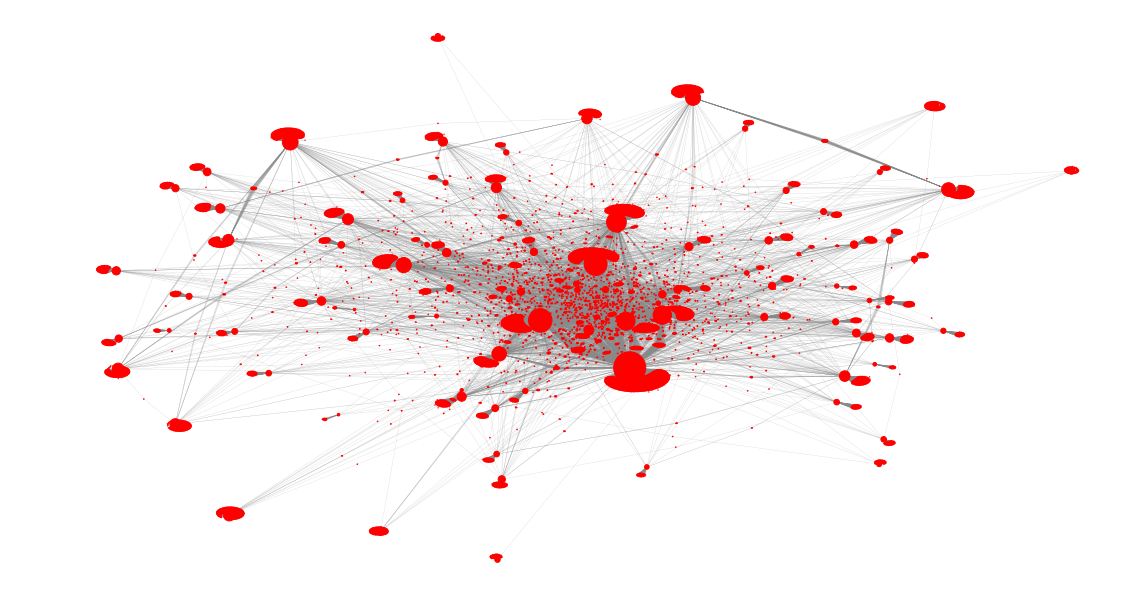

In [30]:
# creating a dic containing all nodes degree
degrees = {}
for node, degree in nx.degree(user_nw_undir):
    degrees[node] = degree
    
# creating a dic containing all edges weight
#weights = {}
#for u, v in user_nw_undir.edges:
#    weights[(u, v)] = user_nw_undir[u][v]['weight']
    
plt.rcParams["figure.figsize"] = [15, 8]
    
nx.draw(user_nw_undir,
        positions,
        cmap=plt.get_cmap('jet'),
        edge_color="#898989",
        #nodelist=degrees.keys(),
        node_size= [v * .2 for v in degrees.values()],
        #node_color = node_colors,
        #border = .1,
        #border_color='black',
        overlap = False,
        width = .1,
        with_labels=False)

plt.show()

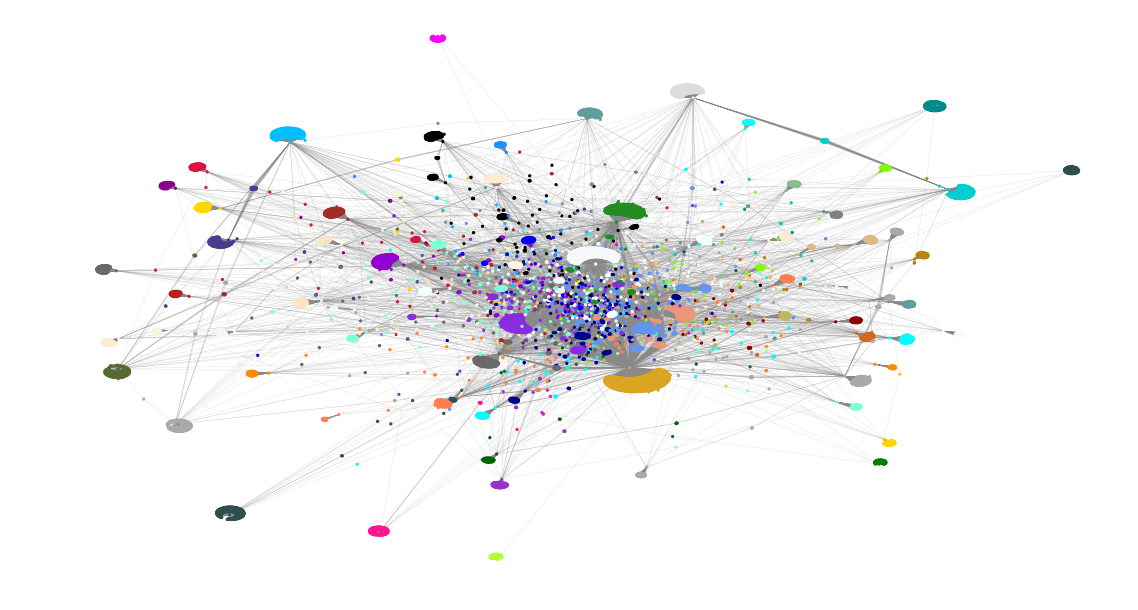

In [38]:
import community
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

partition = community.best_partition(user_nw_undir)

plt.rcParams["figure.figsize"] = [15, 8];

#We create an array with the colors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
com_colors = []
for com in set(partition.values()):
    com_colors.append(list(mcolors.CSS4_COLORS)[com % len(list(mcolors.CSS4_COLORS)) ])

node_colors = [com_colors[partition[node]] for node in user_nw_undir.nodes]

#positions = nx.spring_layout(user_nw_undir,k=0.15,iterations=20)

nx.draw(user_nw_undir,
        positions,
        cmap=plt.get_cmap('jet'),
        node_size = 5,
        node_color = node_colors,
        edge_color = "#898989",
        overlap = False,
        width = .1,
        with_labels=False)
plt.show()

In [32]:
print('nodes', len(user_nw_undir.nodes))
print('edges', len(user_nw_undir.edges))

nodes 34712
edges 40803


34711 34712


Text(0.5,1,'Degree distribution')

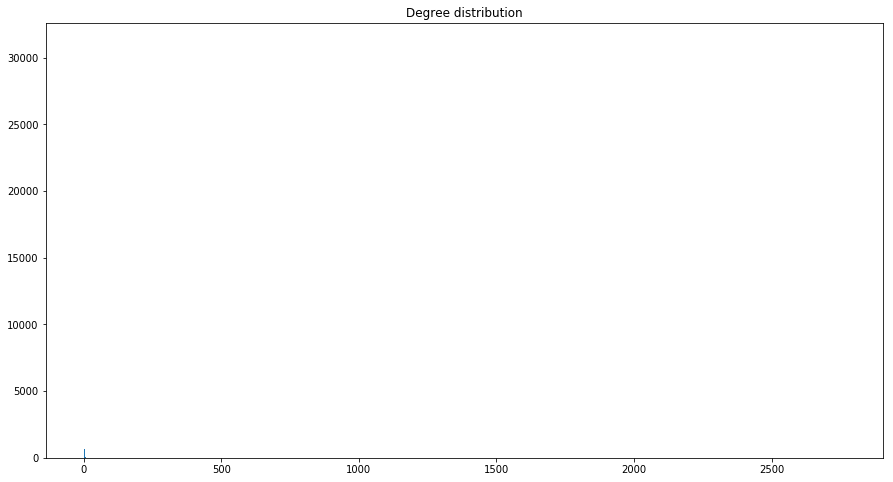

In [33]:
import numpy
import matplotlib.pyplot as plt

degrees = {} 
for node, degree in nx.degree(user_nw_undir):
    degrees[node] = degree
deg = []
for v in degrees.values():
    deg.append(v)
binned_deg = numpy.histogram(deg,bins=sorted(deg))
print(len(binned_deg[0]), len(binned_deg[1]))
plt.bar(binned_deg[1][0:len(binned_deg[0])], binned_deg[0])
plt.title("Degree distribution")

/Users/javiescariz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

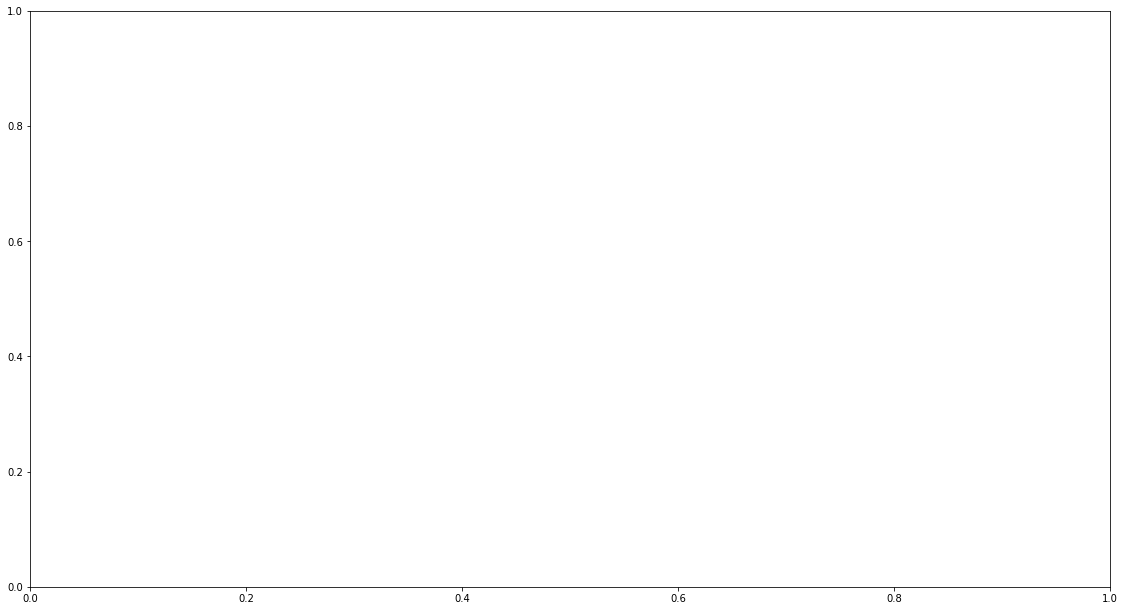

In [40]:
import statistics
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [15, 8];

node_size = []
for elt in list(user_nw_undir.degree()):
    node_size.append(int(elt[1]*5))
    
# here we compute the color of each node regarding their degree
max_size = np.max(node_size)
med_size = statistics.median(node_size)
min_size = np.min(node_size)

def aggregateColors(size):
    if size <= med_size:
        x = (255*(size - min_size)/(med_size - min_size))
        return (1,x/255,0)
    else:
        x = (255*(size - med_size)/(max_size - med_size))
        return ((255 - x)/255,1,0)
        
colors = [aggregateColors(size) for size in node_size]

nx.draw(user_nw_undir, positions, node_size=1, node_color=colors, width=.1)
plt.title("Network of business linked by elite users")
plt.savefig("network_business.png")

In [50]:
friend_count = {user: len(elite_friends[user].values()) for user in elite_friends.keys()}

/Users/javiescariz/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


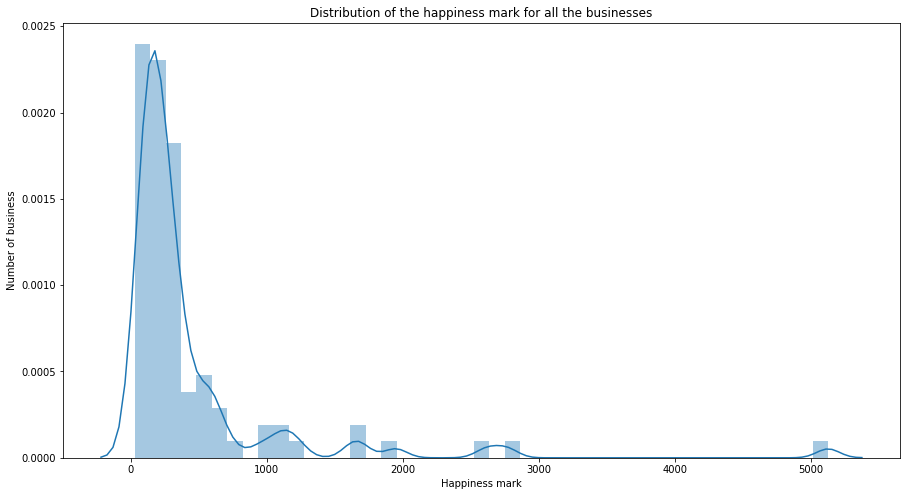

In [57]:
import seaborn as sns
from matplotlib import rcParams

rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

df = pd.DataFrame.from_dict(friend_count, orient='index')

sns.distplot(df, kde=True);
plt.title("Distribution of the happiness mark for all the businesses");
plt.xlabel("Number of friends");
plt.ylabel("Number of relevant users");
#plt.savefig("Website/happiness_distribution.png")

In [56]:
len(friend_count.keys())

92

In [88]:
spark = SparkSession.builder.getOrCreate();
dir_path = '../yelp_dataset/'
spark_df_users = spark.read.json(dir_path + "yelp_academic_dataset_user.json")

spark_df_users = spark_df_users.where("friends != 'None' AND elite != 'None'")
spark_df_users = spark_df_users.drop("average_stars", "compliment_cool", "compliment_cute", "compliment_funny",
                                     "compliment_hot", "compliment_list", "compliment_more", "compliment_note",
                                     "compliment_photos", "compliment_plain", "compliment_profile",
                                     "compliment_writer", "cool", "funny", "useful", "yelping_since")
# spark_df_users.write.format("json").save("elite_users_with_friends.json")

#spark_df_users = spark_df_users.withColumn("friends", split(col("friends"), "\\|"))
el_u_total = spark_df_users.count()
#spark_df_users = spark_df_users.where(spark_df_users.elite.like('2017'))
#spark_df_users = spark_df_users.where(spark_df_users.fans > 10)
#spark_df_users = spark_df_users.where(spark_df_users.review_count > 50)
#spark_df_users.sort('fans', ascending=True).show()
print("Total elite users: ", el_u_total)
el_u_filtered = spark_df_users.count()
print("Only filtered elite users: ", el_u_filtered)

Total elite users:  66871
Only filtered elite users:  66871


In [89]:
take_fans = spark_df_users.select('fans').take(el_u_total)
take_review_count = spark_df_users.select('review_count').take(el_u_total)

In [90]:
fans = [fan[0] for fan in take_fans]
review_count = [rev[0] for rev in take_review_count]

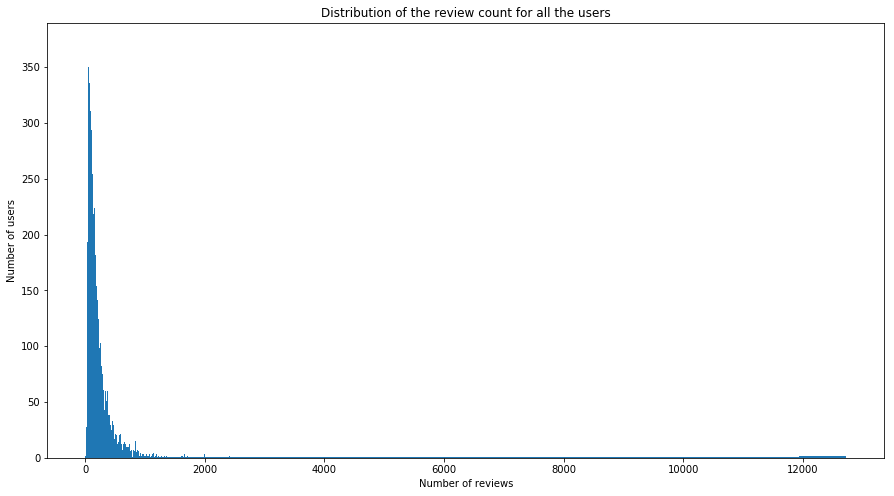

In [99]:
rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'g'


plt.hist(review_count, bins=sorted(review_count))
plt.title("Distribution of the review count for all the users");
plt.xlabel("Number of reviews");
plt.ylabel("Number of users");
plt.savefig("Website/user_review_distribution.png")

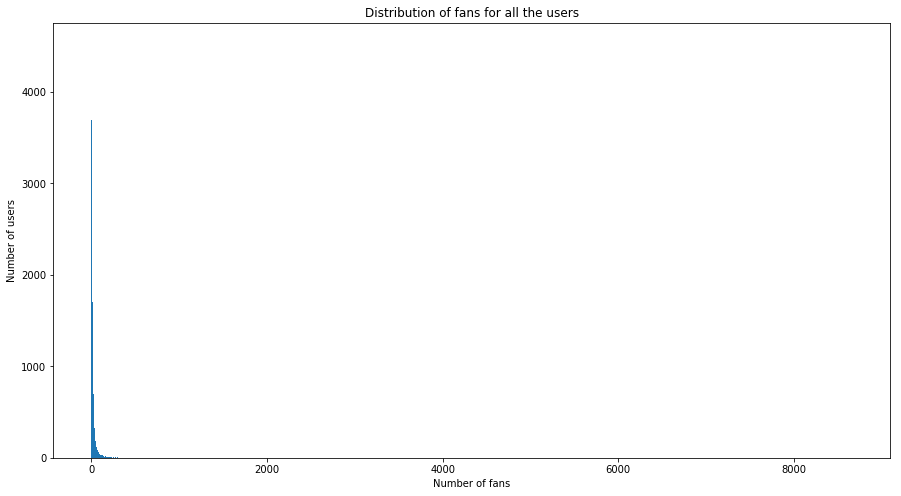

In [105]:
rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'g'

plt.hist(fans, bins=sorted(fans))
plt.title("Distribution of fans for all the users");
plt.xlabel("Number of fans");
plt.ylabel("Number of users");
plt.savefig("Website/user_fan_distribution.png")

[8665,
 2785,
 2311,
 2255,
 2028,
 1990,
 1978,
 1925,
 1897,
 1858,
 1704,
 1593,
 1550,
 1439,
 1418,
 1394,
 1393,
 1360,
 1349,
 1337,
 1311,
 1300,
 1277,
 1186,
 1141,
 1115,
 1107,
 1101,
 1100,
 1085,
 1077,
 1056,
 1051,
 1037,
 1024,
 994,
 993,
 982,
 978,
 971,
 970,
 968,
 968,
 940,
 936,
 936,
 935,
 927,
 914,
 904,
 895,
 887,
 883,
 867,
 860,
 858,
 856,
 851,
 849,
 828,
 809,
 807,
 797,
 795,
 777,
 776,
 776,
 774,
 749,
 747,
 735,
 730,
 727,
 727,
 725,
 720,
 707,
 703,
 697,
 695,
 695,
 693,
 684,
 669,
 667,
 664,
 660,
 657,
 656,
 650,
 644,
 644,
 639,
 638,
 637,
 631,
 628,
 613,
 610,
 606,
 606,
 604,
 604,
 598,
 597,
 596,
 591,
 589,
 587,
 579,
 578,
 577,
 577,
 577,
 576,
 574,
 569,
 569,
 569,
 565,
 564,
 564,
 563,
 559,
 558,
 549,
 547,
 546,
 542,
 541,
 540,
 537,
 537,
 535,
 534,
 532,
 532,
 527,
 527,
 526,
 522,
 520,
 518,
 517,
 515,
 515,
 514,
 510,
 508,
 506,
 506,
 505,
 503,
 502,
 501,
 497,
 494,
 493,
 493,
 492,
 492,